In [1]:
using Distributions
using Random
using StatsBase: ecdf
using StatsPlots
default(fmt=:png)

ECDF(A, x) = count(≤(x), A)/length(A)

ECDF (generic function with 1 method)

In [2]:
function plot_ecdfpval(pvals;
        n = length(pvals), 
        labels = fill("", n),
        linestyles = fill(:auto, n),
        size = (400, 400),
        legend = :bottomright,
        kwargs...
    )
    _tick = Any[0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
    xtick = ytick = (float.(_tick), string.(_tick))
    xlim = ylim = (0.0015, 1.1)
    αs = range(0.002, 1, 1000)
    P = plot()
    for (pval, label, ls) in zip(pvals, labels, linestyles)
        _ecdf_pval = ecdf(pval)
        plot!(αs, α -> _ecdf_pval(α); label, ls, kwargs...)
    end
    plot!(αs, x->x; label="", ls=:dot, alpha=0.5, c=:black)
    plot!(αs, x->0.8x; label="", ls=:dot, alpha=0.3, c=:black)
    plot!(αs, x->1.2x; label="", ls=:dot, alpha=0.3, c=:black)
    plot!(; xscale=:log10, yscale=:log10, xtick, ytick, xlim, ylim)
    plot!(; xguide="α", yguide="probability of P-value ≤ α")
    plot!(; size, legend)
end

plot_ecdfpval (generic function with 1 method)

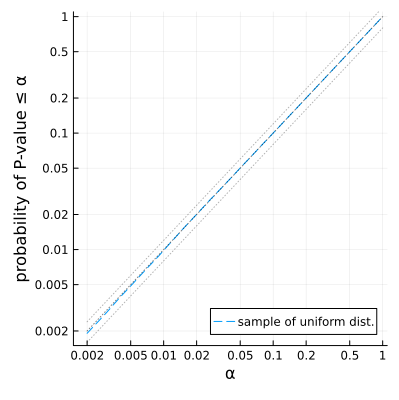

In [3]:
pval = rand(10^6)
plot_ecdfpval([pval]; labels=["sample of uniform dist."])

In [4]:
safediv(x, y) = x == 0 ? zero(x/y) : x/y

expectval(A) = safediv.(sum(A; dims=2) * sum(A; dims=1), sum(A))

function pearson_chisq_stat(A)
    E = expectval(A)
    sum(safediv((a - e)^2, e) for (a, e) in zip(A, E))
end

function pvalue_pearson_chisq(A)
    r, c = size(A)
    df = (r-1)*(c-1)
    chi2 = pearson_chisq_stat(A)
    ccdf(Chisq(df), chi2)
end

pvalue_pearson_chisq (generic function with 1 method)

In [5]:
function sim_pearson_chisq_stat(randfunc, param; L=10^4)
    A = randfunc(param)
    r, c = size(A)
    df = (r-1)*(c-1)
    chisq = zeros(L)
    pval = zeros(L)
    for i in 1:L
        A = randfunc(param)
        chisq[i] = pearson_chisq_stat(A)
        pval[i] = ccdf.(Chisq(df), chisq[i])
    end
    (; pval, chisq)
end

sim_pearson_chisq_stat (generic function with 1 method)

In [6]:
x ⪅ y = x < y || x ≈ y

function pvalue_chisq(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    chi2 = (a+b+c+d)*safediv((a*d - b*c)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chi2)
end

function pvalue_yates(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    N = a+b+c+d
    chi2 = N*safediv(max(0, abs(a*d - b*c) - N/2)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chi2)
end

function pvalue_fisher_central(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    hg = Hypergeometric(a+b, c+d, a+c)
    min(1, 2cdf(hg, a), 2ccdf(hg, a-1))
end

function pvalue_fisher_minlike(A)
    @assert size(A) == (2, 2)
    a, b, c, d = A'
    hg = Hypergeometric(a+b, c+d, a+c)
    pa = pdf(hg, a)
    sum(pdf(hg, x) for x in support(hg) if pdf(hg, x) ⪅ pa)
end

function sim_fisher(randfunc, param; L=10^4)
    pval_central = zeros(L)
    pval_minlike = zeros(L)
    pval_chisq = zeros(L)
    pval_yates = zeros(L)
    Threads.@threads for i in 1:L
        A = randfunc(param)
        pval_central[i] = pvalue_fisher_central(A)
        pval_minlike[i] = pvalue_fisher_minlike(A)
        pval_chisq[i] = pvalue_chisq(A)
        pval_yates[i] = pvalue_yates(A)
    end
    pval_central, pval_minlike, pval_chisq, pval_yates
end

sim_fisher (generic function with 1 method)

A = [1 2 3; 4 5 6; 7 8 9] = [1 2 3; 4 5 6; 7 8 9]
E = expectval(A) = [1.6 2.0 2.4; 4.0 5.0 6.0; 6.4 8.0 9.6]
[randpoissons(E) for _ = 1:10] = [[1 1 1; 6 3 4; 5 5 10], [1 1 1; 3 4 8; 5 4 9], [3 1 1; 3 12 6; 9 13 9], [1 0 4; 5 5 5; 8 7 11], [2 1 0; 7 7 5; 7 6 14], [1 2 6; 6 4 5; 6 8 15], [0 2 0; 4 5 2; 2 10 8], [2 1 2; 6 5 1; 7 11 6], [2 1 3; 7 3 3; 5 10 12], [0 2 2; 5 5 8; 7 10 11]]
  3.998301 seconds (12.23 M allocations: 20.351 GiB, 20.42% gc time, 9.75% compilation time)
ECDF(pval, 0.05) = 0.045573
ECDF(pval, 0.01) = 0.007599


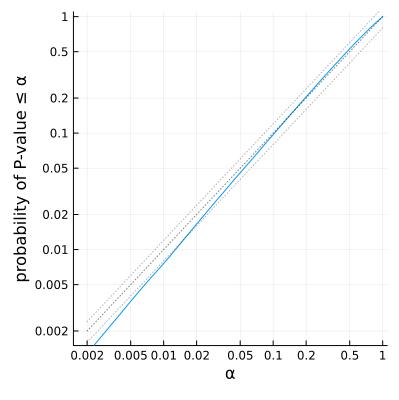

In [7]:
randpoissons(E) = @. rand(Poisson(E))

@show A = [
    1 2 3
    4 5 6
    7 8 9
]

@show E = expectval(A)

@show [randpoissons(E) for _ in 1:10];

@time (; pval) = sim_pearson_chisq_stat(randpoissons, E; L=10^6)

@show ECDF(pval, 0.05)
@show ECDF(pval, 0.01)
plot_ecdfpval([pval]; linestyles=[:solid])

A = [1 2 3; 4 5 6; 7 8 9] = [1 2 3; 4 5 6; 7 8 9]
E = expectval(A) = [1.6 2.0 2.4; 4.0 5.0 6.0; 6.4 8.0 9.6]
N = sum(A) = 45
P = E ./ N = [0.035555555555555556 0.044444444444444446 0.05333333333333333; 0.08888888888888889 0.1111111111111111 0.13333333333333333; 0.14222222222222222 0.17777777777777778 0.21333333333333332]
[randmultinomial((N, P)) for _ = 1:10] = [[2 2 1; 6 7 5; 5 5 12], [2 3 1; 7 3 1; 8 8 12], [0 3 1; 3 3 4; 14 9 8], [2 2 1; 2 8 6; 6 8 10], [1 5 2; 5 6 6; 7 7 6], [3 2 2; 4 8 5; 6 4 11], [3 3 1; 10 5 1; 5 9 8], [2 0 0; 2 3 11; 6 10 11], [1 1 2; 4 6 5; 8 7 11], [3 1 2; 4 5 11; 5 8 6]]
  2.340781 seconds (15.60 M allocations: 20.474 GiB, 18.11% gc time, 1.15% compilation time)
ECDF(pval, 0.05) = 0.045586
ECDF(pval, 0.01) = 0.007609


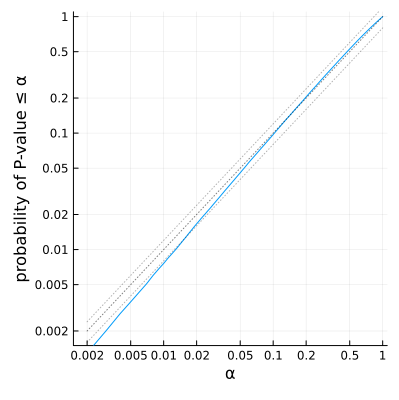

In [8]:
function randmultinomial((N, P))
    A = rand(Multinomial(N, vec(P)))
    reshape(A, size(P))
end

@show A = [
    1 2 3
    4 5 6
    7 8 9
]

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N

@show [randmultinomial((N, P)) for _ in 1:10]

@time (; pval) = sim_pearson_chisq_stat(randmultinomial, (N, P); L=10^6)

@show ECDF(pval, 0.05)
@show ECDF(pval, 0.01)
plot_ecdfpval([pval]; linestyles=[:solid])

A = [1 2 3; 4 5 6; 7 8 9] = [1 2 3; 4 5 6; 7 8 9]
E = expectval(A) = [1.6 2.0 2.4; 4.0 5.0 6.0; 6.4 8.0 9.6]
Ns = sum(A; dims = 2) = [6; 15; 24;;]
Ps = E ./ Ns = [0.26666666666666666 0.3333333333333333 0.39999999999999997; 0.26666666666666666 0.3333333333333333 0.4; 0.26666666666666666 0.3333333333333333 0.39999999999999997]
[randmultinomials((Ns, Ps)) for _ = 1:10] = [[2 1 3; 3 7 5; 5 8 11], [1 4 1; 6 5 4; 5 7 12], [2 3 1; 4 4 7; 7 5 12], [2 2 2; 2 7 6; 8 8 8], [2 1 3; 3 6 6; 11 7 6], [1 4 1; 2 6 7; 6 6 12], [1 1 4; 3 2 10; 9 9 6], [3 2 1; 3 8 4; 7 5 12], [2 2 2; 3 2 10; 5 12 7], [1 0 5; 5 5 5; 5 5 14]]
  2.322860 seconds (11.60 M allocations: 20.310 GiB, 17.97% gc time, 1.21% compilation time)
ECDF(pval, 0.05) = 0.046534
ECDF(pval, 0.01) = 0.008183


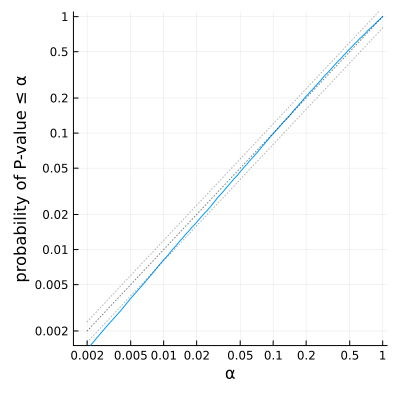

In [9]:
function randmultinomials((Ns, Ps))
    r = length(Ns)
    A = similar(Ps, Int)
    for i in 1:r
        rand!(Multinomial(Ns[i], @view(Ps[i,:])), @view(A[i,:]))
    end
    A
end

@show A = [
    1 2 3
    4 5 6
    7 8 9
]

@show E = expectval(A)
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@show [randmultinomials((Ns, Ps)) for _ in 1:10]

@time (; pval) = sim_pearson_chisq_stat(randmultinomials, (Ns, Ps); L=10^6)

@show ECDF(pval, 0.05)
@show ECDF(pval, 0.01)
plot_ecdfpval([pval]; linestyles=[:solid])

A = [1 2 3; 4 5 6; 7 8 9] = [1 2 3; 4 5 6; 7 8 9]
pearson_chisq_stat(A) = 0.46875
pvalue_pearson_chisq(A) = 0.9764709962058341
E = expectval(A) = [1.6 2.0 2.4; 4.0 5.0 6.0; 6.4 8.0 9.6]
N = sum(A) = 45
P = E ./ N = [0.035555555555555556 0.044444444444444446 0.05333333333333333; 0.08888888888888889 0.1111111111111111 0.13333333333333333; 0.14222222222222222 0.17777777777777778 0.21333333333333332]
Ns = sum(A; dims = 2) = [6; 15; 24;;]
Ps = E ./ Ns = [0.26666666666666666 0.3333333333333333 0.39999999999999997; 0.26666666666666666 0.3333333333333333 0.4; 0.26666666666666666 0.3333333333333333 0.39999999999999997]
  2.162972 seconds (11.57 M allocations: 20.308 GiB, 17.66% gc time)
  2.265244 seconds (15.57 M allocations: 20.472 GiB, 17.26% gc time)
  1.981005 seconds (11.57 M allocations: 20.308 GiB, 18.09% gc time)
ECDF(pval_multinomials, 0.05) = 0.046744
ECDF(pval_multinomial, 0.05) = 0.045495
ECDF(pval_poissons, 0.05) = 0.045445
ECDF(pval_multinomials, 0.01) = 0.008138
ECDF(pval_multin

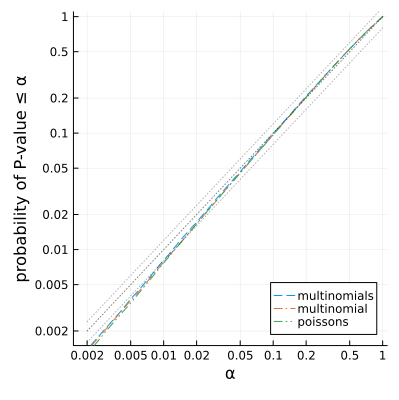

In [10]:
@show A = [
    1 2 3
    4 5 6
    7 8 9
]

@show pearson_chisq_stat(A)
@show pvalue_pearson_chisq(A)
@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time (; pval) = sim_pearson_chisq_stat(randmultinomials, (Ns, Ps); L=10^6)
pval_multinomials = pval
@time (; pval) = sim_pearson_chisq_stat(randmultinomial, (N, P); L=10^6)
pval_multinomial = pval
@time (; pval) = sim_pearson_chisq_stat(randpoissons, E; L=10^6)
pval_poissons = pval

@show ECDF(pval_multinomials, 0.05)
@show ECDF(pval_multinomial, 0.05)
@show ECDF(pval_poissons, 0.05)
@show ECDF(pval_multinomials, 0.01)
@show ECDF(pval_multinomial, 0.01)
@show ECDF(pval_poissons, 0.01)

plot_ecdfpval(
    [pval_multinomials, pval_multinomial, pval_poissons];
    labels=["multinomials", "multinomial", "poissons"])

A = [7 4 23; 10 8 8] = [7 4 23; 10 8 8]
pearson_chisq_stat(A) = 8.199919290442788
pvalue_pearson_chisq(A) = 0.016573344201902547
E = expectval(A) = [9.633333333333333 6.8 17.566666666666666; 7.366666666666666 5.2 13.433333333333334]
N = sum(A) = 60
P = E ./ N = [0.16055555555555553 0.11333333333333333 0.29277777777777775; 0.12277777777777778 0.08666666666666667 0.2238888888888889]
Ns = sum(A; dims = 2) = [34; 26;;]
Ps = E ./ Ns = [0.2833333333333333 0.19999999999999998 0.5166666666666666; 0.2833333333333333 0.2 0.5166666666666667]
  2.035113 seconds (11.62 M allocations: 20.277 GiB, 19.83% gc time)
  2.177626 seconds (15.62 M allocations: 20.441 GiB, 19.25% gc time)
  1.879340 seconds (11.62 M allocations: 20.277 GiB, 20.85% gc time)
ECDF(pval_multinomials, 0.05) = 0.05076
ECDF(pval_multinomial, 0.05) = 0.050346
ECDF(pval_poissons, 0.05) = 0.050541
ECDF(pval_multinomials, 0.01) = 0.009054
ECDF(pval_multinomial, 0.01) = 0.008936
ECDF(pval_poissons, 0.01) = 0.008926


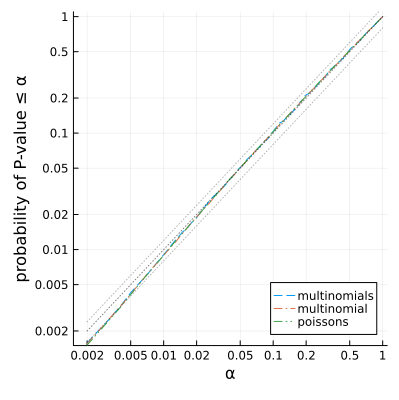

In [11]:
@show A = [
     7  4 23
    10  8  8
]

@show pearson_chisq_stat(A)
@show pvalue_pearson_chisq(A)
@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time (; pval) = sim_pearson_chisq_stat(randmultinomials, (Ns, Ps); L=10^6)
pval_multinomials = pval
@time (; pval) = sim_pearson_chisq_stat(randmultinomial, (N, P); L=10^6)
pval_multinomial = pval
@time (; pval) = sim_pearson_chisq_stat(randpoissons, E; L=10^6)
pval_poissons = pval

@show ECDF(pval_multinomials, 0.05)
@show ECDF(pval_multinomial, 0.05)
@show ECDF(pval_poissons, 0.05)
@show ECDF(pval_multinomials, 0.01)
@show ECDF(pval_multinomial, 0.01)
@show ECDF(pval_poissons, 0.01)

plot_ecdfpval(
    [pval_multinomials, pval_multinomial, pval_poissons];
    labels=["multinomials", "multinomial", "poissons"])

A = [7 2 23; 10 4 8] = [7 2 23; 10 4 8]
pearson_chisq_stat(A) = 6.836747455580473
pvalue_pearson_chisq(A) = 0.032765677544625275
E = expectval(A) = [10.074074074074074 3.5555555555555554 18.37037037037037; 6.925925925925926 2.4444444444444446 12.62962962962963]
N = sum(A) = 54
P = E ./ N = [0.18655692729766804 0.06584362139917695 0.3401920438957476; 0.12825788751714676 0.04526748971193416 0.23388203017832648]
Ns = sum(A; dims = 2) = [32; 22;;]
Ps = E ./ Ns = [0.3148148148148148 0.1111111111111111 0.5740740740740741; 0.3148148148148148 0.11111111111111112 0.5740740740740741]
  1.991966 seconds (11.61 M allocations: 20.274 GiB, 19.54% gc time)
  2.187111 seconds (15.61 M allocations: 20.439 GiB, 19.57% gc time)
  1.978463 seconds (11.61 M allocations: 20.275 GiB, 22.32% gc time)
ECDF(pval_multinomials, 0.05) = 0.047482
ECDF(pval_multinomial, 0.05) = 0.046923
ECDF(pval_poissons, 0.05) = 0.047007
ECDF(pval_multinomials, 0.01) = 0.007622
ECDF(pval_multinomial, 0.01) = 0.007668
ECDF(pval_poi

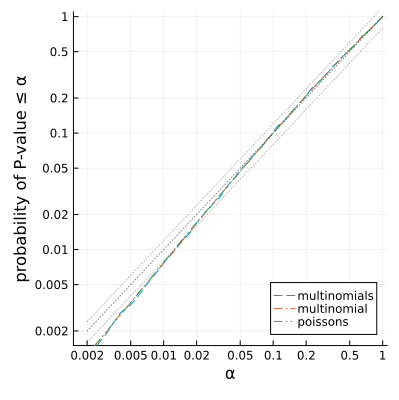

In [12]:
@show A = [
     7  2 23
    10  4  8
]

@show pearson_chisq_stat(A)
@show pvalue_pearson_chisq(A)
@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time (; pval) = sim_pearson_chisq_stat(randmultinomials, (Ns, Ps); L=10^6)
pval_multinomials = pval
@time (; pval) = sim_pearson_chisq_stat(randmultinomial, (N, P); L=10^6)
pval_multinomial = pval
@time (; pval) = sim_pearson_chisq_stat(randpoissons, E; L=10^6)
pval_poissons = pval

@show ECDF(pval_multinomials, 0.05)
@show ECDF(pval_multinomial, 0.05)
@show ECDF(pval_poissons, 0.05)
@show ECDF(pval_multinomials, 0.01)
@show ECDF(pval_multinomial, 0.01)
@show ECDF(pval_poissons, 0.01)

plot_ecdfpval(
    [pval_multinomials, pval_multinomial, pval_poissons];
    labels=["multinomials", "multinomial", "poissons"])

A = [7 4 23; 5 4 4] = [7 4 23; 5 4 4]
pearson_chisq_stat(A) = 5.398462376403552
pvalue_pearson_chisq(A) = 0.06725720099757504
E = expectval(A) = [8.680851063829786 5.787234042553192 19.53191489361702; 3.3191489361702127 2.2127659574468086 7.468085106382978]
N = sum(A) = 47
P = E ./ N = [0.18469895880488907 0.1231326392032594 0.41557265731100046; 0.07062019013128112 0.047080126754187414 0.15889542779538252]
Ns = sum(A; dims = 2) = [34; 13;;]
Ps = E ./ Ns = [0.2553191489361702 0.17021276595744683 0.5744680851063829; 0.2553191489361702 0.1702127659574468 0.5744680851063829]
  2.101489 seconds (11.62 M allocations: 20.276 GiB, 21.27% gc time)
  2.089601 seconds (15.61 M allocations: 20.439 GiB, 20.40% gc time)
  1.875442 seconds (11.61 M allocations: 20.275 GiB, 21.03% gc time)
ECDF(pval_multinomials, 0.05) = 0.047025
ECDF(pval_multinomial, 0.05) = 0.047245
ECDF(pval_poissons, 0.05) = 0.047211
ECDF(pval_multinomials, 0.01) = 0.008464
ECDF(pval_multinomial, 0.01) = 0.00889
ECDF(pval_poisson

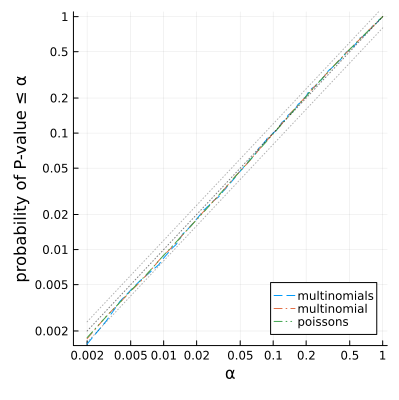

In [13]:
@show A = [
     7  4 23
     5  4  4
]

@show pearson_chisq_stat(A)
@show pvalue_pearson_chisq(A)
@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time (; pval) = sim_pearson_chisq_stat(randmultinomials, (Ns, Ps); L=10^6)
pval_multinomials = pval
@time (; pval) = sim_pearson_chisq_stat(randmultinomial, (N, P); L=10^6)
pval_multinomial = pval
@time (; pval) = sim_pearson_chisq_stat(randpoissons, E; L=10^6)
pval_poissons = pval

@show ECDF(pval_multinomials, 0.05)
@show ECDF(pval_multinomial, 0.05)
@show ECDF(pval_poissons, 0.05)
@show ECDF(pval_multinomials, 0.01)
@show ECDF(pval_multinomial, 0.01)
@show ECDF(pval_poissons, 0.01)

plot_ecdfpval(
    [pval_multinomials, pval_multinomial, pval_poissons];
    labels=["multinomials", "multinomial", "poissons"])

A = [7 2; 2 9] = [7 2; 2 9]
pvalue_chisq(A) = 0.007693972527542988
pvalue_yates(A) = 0.026864471961340213
pvalue_fisher_central(A) = 0.0247678018575851
pvalue_fisher_minlike(A) = 0.02155275065491782
E = expectval(A) = [4.05 4.95; 4.95 6.05]
N = sum(A) = 20
P = E ./ N = [0.20249999999999999 0.2475; 0.2475 0.3025]
Ns = sum(A; dims = 2) = [9; 11;;]
Ps = E ./ Ns = [0.44999999999999996 0.55; 0.45 0.5499999999999999]
  1.034747 seconds (1.23 M allocations: 138.241 MiB, 0.70% gc time, 121.58% compilation time)
ECDF(pval_chisq, 0.05) = 0.790486
ECDF(pval_yates, 0.05) = 0.604749
ECDF(pval_fisher_central, 0.05) = 0.616526
ECDF(pval_fishet_minlike, 0.05) = 0.682088
ECDF(pval_chisq, 0.01) = 0.554739
ECDF(pval_yates, 0.01) = 0.336358
ECDF(pval_fisher_central, 0.01) = 0.366135
ECDF(pval_fishet_minlike, 0.01) = 0.42799


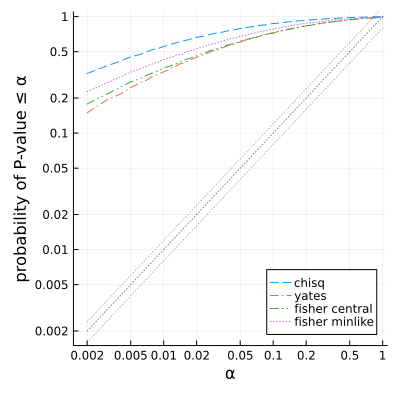

In [14]:
@show A = [
    7 2
    2 9
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randpoissons, A; L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 6] = [7 2; 2 6]
pvalue_chisq(A) = 0.029549015619382227
pvalue_yates(A) = 0.09115659051595472
pvalue_fisher_central(A) = 0.08893459481694779
pvalue_fisher_minlike(A) = 0.05668449197860966
E = expectval(A) = [4.764705882352941 4.235294117647059; 4.235294117647059 3.764705882352941]
N = sum(A) = 17
P = E ./ N = [0.28027681660899656 0.24913494809688583; 0.24913494809688583 0.22145328719723184]
Ns = sum(A; dims = 2) = [9; 8;;]
Ps = E ./ Ns = [0.5294117647058824 0.47058823529411764; 0.5294117647058824 0.47058823529411764]
  0.839532 seconds (1.00 M allocations: 122.091 MiB)
ECDF(pval_chisq, 0.05) = 0.608353
ECDF(pval_yates, 0.05) = 0.376922
ECDF(pval_fisher_central, 0.05) = 0.392055
ECDF(pval_fishet_minlike, 0.05) = 0.466028
ECDF(pval_chisq, 0.01) = 0.342644
ECDF(pval_yates, 0.01) = 0.153756
ECDF(pval_fisher_central, 0.01) = 0.177464
ECDF(pval_fishet_minlike, 0.01) = 0.222409


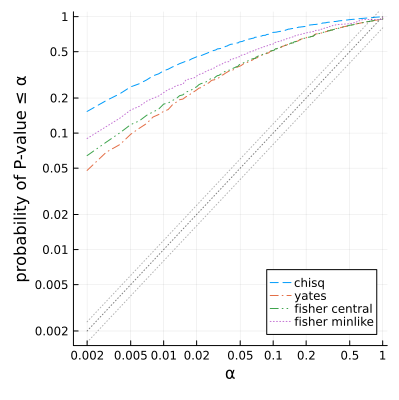

In [15]:
@show A = [
    7 2
    2 6
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randpoissons, A; L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 6] = [7 2; 2 6]
pvalue_chisq(A) = 0.029549015619382227
pvalue_yates(A) = 0.09115659051595472
pvalue_fisher_central(A) = 0.08893459481694779
pvalue_fisher_minlike(A) = 0.05668449197860966
E = expectval(A) = [4.764705882352941 4.235294117647059; 4.235294117647059 3.764705882352941]
N = sum(A) = 17
P = E ./ N = [0.28027681660899656 0.24913494809688583; 0.24913494809688583 0.22145328719723184]
Ns = sum(A; dims = 2) = [9; 8;;]
Ps = E ./ Ns = [0.5294117647058824 0.47058823529411764; 0.5294117647058824 0.47058823529411764]
  1.029400 seconds (1.04 M allocations: 124.835 MiB, 32.78% compilation time)
ECDF(pval_chisq, 0.05) = 0.055747
ECDF(pval_yates, 0.05) = 0.012865
ECDF(pval_fisher_central, 0.05) = 0.014742
ECDF(pval_fishet_minlike, 0.05) = 0.024198
ECDF(pval_chisq, 0.01) = 0.009713
ECDF(pval_yates, 0.01) = 0.001378
ECDF(pval_fisher_central, 0.01) = 0.002023
ECDF(pval_fishet_minlike, 0.01) = 0.003412


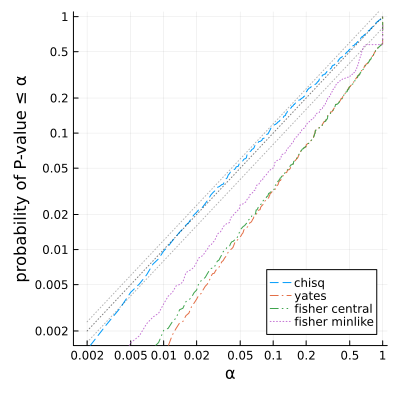

In [16]:
@show A = [
    7 2
    2 6
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randpoissons, E; L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 9] = [7 2; 2 9]
pvalue_chisq(A) = 0.007693972527542988
pvalue_yates(A) = 0.026864471961340213
pvalue_fisher_central(A) = 0.0247678018575851
pvalue_fisher_minlike(A) = 0.02155275065491782
E = expectval(A) = [4.05 4.95; 4.95 6.05]
N = sum(A) = 20
P = E ./ N = [0.20249999999999999 0.2475; 0.2475 0.3025]
Ns = sum(A; dims = 2) = [9; 11;;]
Ps = E ./ Ns = [0.44999999999999996 0.55; 0.45 0.5499999999999999]
  1.021101 seconds (5.13 M allocations: 298.542 MiB, 2.23% gc time, 32.61% compilation time)
ECDF(pval_chisq, 0.05) = 0.796512
ECDF(pval_yates, 0.05) = 0.611448
ECDF(pval_fisher_central, 0.05) = 0.632271
ECDF(pval_fishet_minlike, 0.05) = 0.664158
ECDF(pval_chisq, 0.01) = 0.602469
ECDF(pval_yates, 0.01) = 0.373768
ECDF(pval_fisher_central, 0.01) = 0.387196
ECDF(pval_fishet_minlike, 0.01) = 0.431829


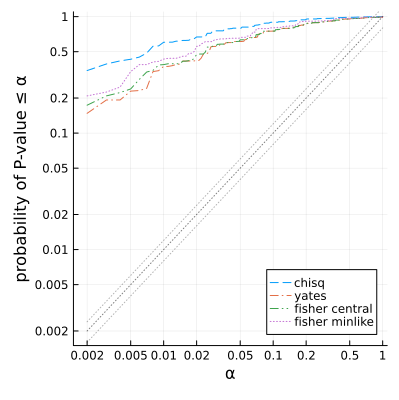

In [17]:
@show A = [
    7 2
    2 9
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randmultinomial, (N, A/N); L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 6] = [7 2; 2 6]
pvalue_chisq(A) = 0.029549015619382227
pvalue_yates(A) = 0.09115659051595472
pvalue_fisher_central(A) = 0.08893459481694779
pvalue_fisher_minlike(A) = 0.05668449197860966
E = expectval(A) = [4.764705882352941 4.235294117647059; 4.235294117647059 3.764705882352941]
N = sum(A) = 17
P = E ./ N = [0.28027681660899656 0.24913494809688583; 0.24913494809688583 0.22145328719723184]
Ns = sum(A; dims = 2) = [9; 8;;]
Ps = E ./ Ns = [0.5294117647058824 0.47058823529411764; 0.5294117647058824 0.47058823529411764]
  0.835735 seconds (5.00 M allocations: 289.938 MiB)
ECDF(pval_chisq, 0.05) = 0.618705
ECDF(pval_yates, 0.05) = 0.391716
ECDF(pval_fisher_central, 0.05) = 0.391716
ECDF(pval_fishet_minlike, 0.05) = 0.506344
ECDF(pval_chisq, 0.01) = 0.375136
ECDF(pval_yates, 0.01) = 0.168862
ECDF(pval_fisher_central, 0.01) = 0.167649
ECDF(pval_fishet_minlike, 0.01) = 0.235129


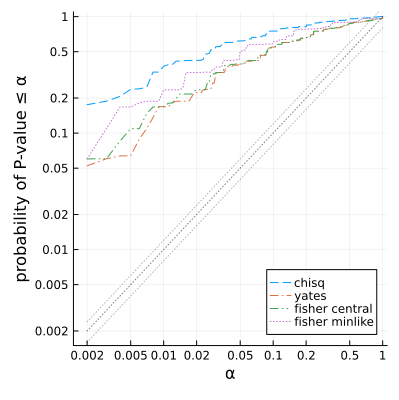

In [18]:
@show A = [
    7 2
    2 6
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randmultinomial, (N, A/N); L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 6] = [7 2; 2 6]
pvalue_chisq(A) = 0.029549015619382227
pvalue_yates(A) = 0.09115659051595472
pvalue_fisher_central(A) = 0.08893459481694779
pvalue_fisher_minlike(A) = 0.05668449197860966
E = expectval(A) = [4.764705882352941 4.235294117647059; 4.235294117647059 3.764705882352941]
N = sum(A) = 17
P = E ./ N = [0.28027681660899656 0.24913494809688583; 0.24913494809688583 0.22145328719723184]
Ns = sum(A; dims = 2) = [9; 8;;]
Ps = E ./ Ns = [0.5294117647058824 0.47058823529411764; 0.5294117647058824 0.47058823529411764]
  0.997737 seconds (5.00 M allocations: 289.936 MiB)
ECDF(pval_chisq, 0.05) = 0.054349
ECDF(pval_yates, 0.05) = 0.014223
ECDF(pval_fisher_central, 0.05) = 0.014223
ECDF(pval_fishet_minlike, 0.05) = 0.032974
ECDF(pval_chisq, 0.01) = 0.010992
ECDF(pval_yates, 0.01) = 0.001766
ECDF(pval_fisher_central, 0.01) = 0.001757
ECDF(pval_fishet_minlike, 0.01) = 0.004287


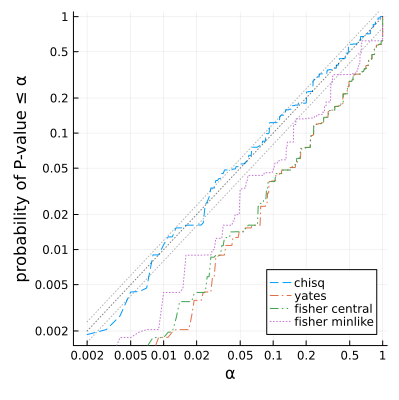

In [19]:
@show A = [
    7 2
    2 6
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randmultinomial, (N, P); L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 9] = [7 2; 2 9]
pvalue_chisq(A) = 0.007693972527542988
pvalue_yates(A) = 0.026864471961340213
pvalue_fisher_central(A) = 0.0247678018575851
pvalue_fisher_minlike(A) = 0.02155275065491782
E = expectval(A) = [4.05 4.95; 4.95 6.05]
N = sum(A) = 20
P = E ./ N = [0.20249999999999999 0.2475; 0.2475 0.3025]
Ns = sum(A; dims = 2) = [9; 11;;]
Ps = E ./ Ns = [0.44999999999999996 0.55; 0.45 0.5499999999999999]
  1.076726 seconds (1.14 M allocations: 131.745 MiB, 0.97% gc time, 37.11% compilation time)
ECDF(pval_chisq, 0.05) = 0.812524
ECDF(pval_yates, 0.05) = 0.632102
ECDF(pval_fisher_central, 0.05) = 0.655767
ECDF(pval_fishet_minlike, 0.05) = 0.682768
ECDF(pval_chisq, 0.01) = 0.632102
ECDF(pval_yates, 0.01) = 0.410113
ECDF(pval_fisher_central, 0.01) = 0.419313
ECDF(pval_fishet_minlike, 0.01) = 0.482385


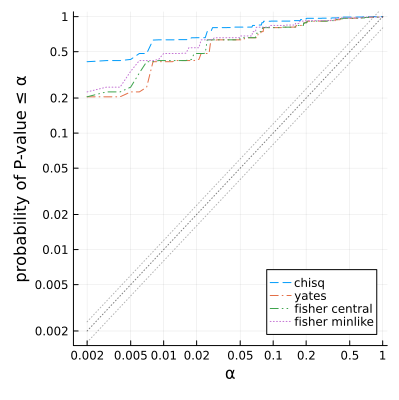

In [20]:
@show A = [
    7 2
    2 9
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randmultinomials, (Ns, A ./ Ns); L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 6] = [7 2; 2 6]
pvalue_chisq(A) = 0.029549015619382227
pvalue_yates(A) = 0.09115659051595472
pvalue_fisher_central(A) = 0.08893459481694779
pvalue_fisher_minlike(A) = 0.05668449197860966
E = expectval(A) = [4.764705882352941 4.235294117647059; 4.235294117647059 3.764705882352941]
N = sum(A) = 17
P = E ./ N = [0.28027681660899656 0.24913494809688583; 0.24913494809688583 0.22145328719723184]
Ns = sum(A; dims = 2) = [9; 8;;]
Ps = E ./ Ns = [0.5294117647058824 0.47058823529411764; 0.5294117647058824 0.47058823529411764]
  0.895934 seconds (1.00 M allocations: 122.091 MiB)
ECDF(pval_chisq, 0.05) = 0.634922
ECDF(pval_yates, 0.05) = 0.415206
ECDF(pval_fisher_central, 0.05) = 0.415206
ECDF(pval_fishet_minlike, 0.05) = 0.534132
ECDF(pval_chisq, 0.01) = 0.40634
ECDF(pval_yates, 0.01) = 0.19963
ECDF(pval_fisher_central, 0.01) = 0.19963
ECDF(pval_fishet_minlike, 0.01) = 0.241927


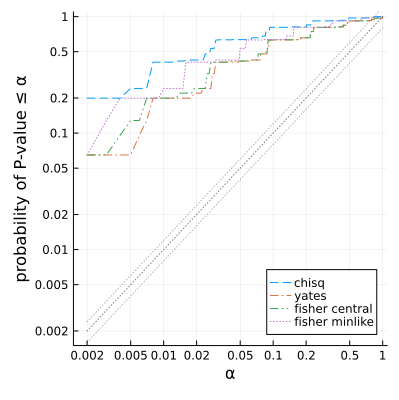

In [21]:
@show A = [
    7 2
    2 6
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randmultinomials, (Ns, A ./ Ns); L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])

A = [7 2; 2 6] = [7 2; 2 6]
pvalue_chisq(A) = 0.029549015619382227
pvalue_yates(A) = 0.09115659051595472
pvalue_fisher_central(A) = 0.08893459481694779
pvalue_fisher_minlike(A) = 0.05668449197860966
E = expectval(A) = [4.764705882352941 4.235294117647059; 4.235294117647059 3.764705882352941]
N = sum(A) = 17
P = E ./ N = [0.28027681660899656 0.24913494809688583; 0.24913494809688583 0.22145328719723184]
Ns = sum(A; dims = 2) = [9; 8;;]
Ps = E ./ Ns = [0.5294117647058824 0.47058823529411764; 0.5294117647058824 0.47058823529411764]
  1.045820 seconds (1.00 M allocations: 122.091 MiB)
ECDF(pval_chisq, 0.05) = 0.052196
ECDF(pval_yates, 0.05) = 0.014653
ECDF(pval_fisher_central, 0.05) = 0.014653
ECDF(pval_fishet_minlike, 0.05) = 0.033909
ECDF(pval_chisq, 0.01) = 0.012646
ECDF(pval_yates, 0.01) = 0.002314
ECDF(pval_fisher_central, 0.01) = 0.002314
ECDF(pval_fishet_minlike, 0.01) = 0.004487


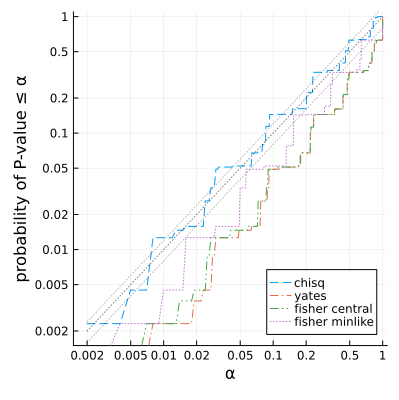

In [22]:
@show A = [
    7 2
    2 6
]

@show pvalue_chisq(A)
@show pvalue_yates(A)
@show pvalue_fisher_central(A)
@show pvalue_fisher_minlike(A)

@show E = expectval(A)
@show N = sum(A)
@show P = E ./ N
@show Ns = sum(A; dims=2)
@show Ps = E ./ Ns

@time pval_fisher_central, pval_fishet_minlike, pval_chisq, pval_yates = sim_fisher(randmultinomials, (Ns, Ps); L=10^6)

@show ECDF(pval_chisq, 0.05)
@show ECDF(pval_yates, 0.05)
@show ECDF(pval_fisher_central, 0.05)
@show ECDF(pval_fishet_minlike, 0.05)
@show ECDF(pval_chisq, 0.01)
@show ECDF(pval_yates, 0.01)
@show ECDF(pval_fisher_central, 0.01)
@show ECDF(pval_fishet_minlike, 0.01)

plot_ecdfpval(
    [pval_chisq, pval_yates, pval_fisher_central, pval_fishet_minlike];
    labels=["chisq", "yates", "fisher central", "fisher minlike"])